# Interpretation

### Load videos + clusters

In [44]:
from pathlib import Path
import pandas as pd
import numpy as np
import av

#Define paths
ROOT = Path("..") 
CLUSTER_CSV = ROOT / "Interpretation" / "cluster_links.csv"
INTERPRET_CSV = ROOT / "Interpretation" / "interpretation.csv"
VIDEOS_DIR = ROOT / "Data" / "Videos"
AUDIO_DIR = ROOT / "Interpretation" / "audio"

#parameters (Can adjust )
FPS_SAMPLE = 2
DIFF_THRESH = 25
EDGE_THRESH = 20

clusters = pd.read_csv("cluster_links.csv")

#videos location
clusters = pd.read_csv(CLUSTER_CSV)
clusters["video_path"] = clusters["video_id"].apply(lambda vid: VIDEOS_DIR / f"{vid}.mp4")
clusters["audio_path"] = clusters["video_id"].apply(lambda vid: AUDIO_DIR / f"{vid}.mp3")

### Pacing 



Measure motion by finding average pixel change and Cut rate by frame to frame difference. 

In [45]:
def pacing_metrics(video_path, fps_sample=FPS_SAMPLE, diff_thresh=DIFF_THRESH):
    container = av.open(str(video_path))
    stream = container.streams.video[0]
    src_fps = float(stream.average_rate) if stream.average_rate else 30.0
    step = max(1, int(src_fps / fps_sample))

    prev = None
    diffs = []
    cuts = 0
    frame_idx = 0
    total_frames = 0

    for frame in container.decode(video=0):
        total_frames += 1
        if frame_idx % step != 0:
            frame_idx += 1
            continue
        #convert to grayscale
        gray = frame.to_ndarray(format="gray")
        if prev is not None:
            #average difference between frames
            diff = np.mean(np.abs(gray.astype(np.float32) - prev.astype(np.float32)))
            diffs.append(diff)
            if diff > diff_thresh:
                cuts += 1
        prev = gray
        frame_idx += 1

    duration_s = total_frames / src_fps if src_fps > 0 else 0.0
    return {
        "motion_mean": float(np.mean(diffs)) if diffs else 0.0,
        "cut_rate_per_min": float(cuts / max(duration_s / 60.0, 1e-6)),
    }

pacing_rows = []
#iterate through videos
for i, (_, row) in enumerate(clusters.iterrows(), start=1):
    print(f"{i}/{len(clusters)} {row['video_id']}")
    if row["video_path"].exists():
        m = pacing_metrics(row["video_path"])
    else:
        m = {"motion_mean": 0.0, "cut_rate_per_min": 0.0}
    m["video_id"] = row["video_id"]
    pacing_rows.append(m)

pacing_df = pd.DataFrame(pacing_rows)

#save 
base = clusters[["video_id", "cluster", "url"]].copy()
out_df = base.merge(pacing_df, on="video_id", how="left")
out_df.to_csv(INTERPRET_CSV, index=False)


1/222 challenge Shorts13
2/222 challenge Shorts16
3/222 challenge Shorts19
4/222 challenge Shorts9
5/222 funny Shorts10
6/222 funny Shorts4
7/222 meme Shorts7
8/222 recipe Shorts11
9/222 recipe Shorts15
10/222 recipe Shorts20
11/222 recipe Shorts3
12/222 recipe Shorts8
13/222 recipe Shorts9
14/222 tech Shorts13
15/222 tech Shorts14
16/222 tech Shorts16
17/222 tech Shorts17
18/222 tech Shorts18
19/222 tech Shorts4
20/222 travel Shorts15
21/222 travel Shorts17
22/222 travel Shorts8
23/222 ai Shorts10
24/222 ai Shorts3
25/222 challenge Shorts5
26/222 educational Shorts8
27/222 fashion Shorts10
28/222 fashion Shorts12
29/222 fashion Shorts14
30/222 fashion Shorts2
31/222 gaming Shorts11
32/222 gaming Shorts14
33/222 gaming Shorts17
34/222 gaming Shorts3
35/222 gaming Shorts5
36/222 motivational Shorts10
37/222 motivational Shorts11
38/222 motivational Shorts15
39/222 motivational Shorts20
40/222 music Shorts14
41/222 music Shorts7
42/222 random Shorts12
43/222 reaction Shorts11
44/222 reac

Visualize the pacing in each cluster

<Figure size 1000x400 with 0 Axes>

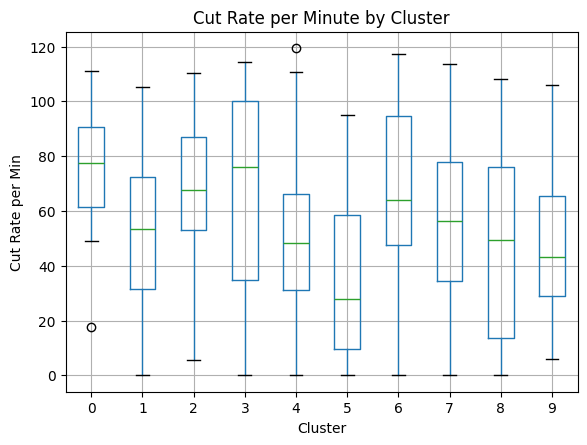

<Figure size 1000x400 with 0 Axes>

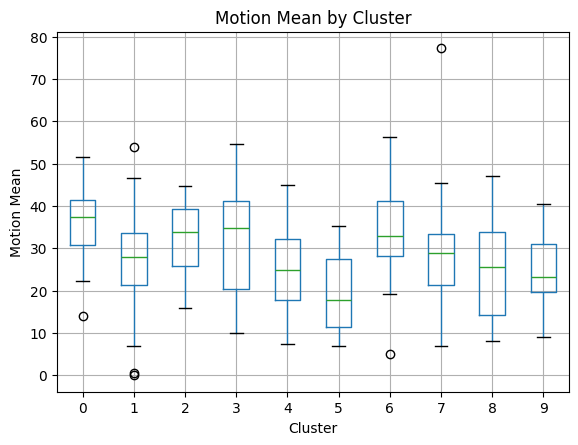

In [46]:
import matplotlib.pyplot as plt

df = pd.read_csv("interpretation.csv")

# Boxplot for cut rate
plt.figure(figsize=(10,4))
df.boxplot(column="cut_rate_per_min", by="cluster")
plt.suptitle("")
plt.title("Cut Rate per Minute by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cut Rate per Min")
plt.show()

# Boxplot for motion
plt.figure(figsize=(10,4))
df.boxplot(column="motion_mean", by="cluster")
plt.suptitle("")
plt.title("Motion Mean by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Motion Mean")
plt.show()

### Audio Energy



**audio_rms_mean** = overall loudness  
  High -> music/shouting/crowd noise  
  Low -> quiet narration or calm videos  

**audio_rms_std** = how much loudness changes  
  High -> dynamic audio (drops, emphasis, punchlines)  
  Low -> steady background or monotone speech  

In [47]:
def audio_energy_metrics(audio_path):
    if not Path(audio_path).exists():
        return {"audio_rms_mean": 0.0, "audio_rms_std": 0.0}

    container = av.open(str(audio_path))
    audio_streams = [s for s in container.streams if s.type == "audio"]
    if not audio_streams:
        return {"audio_rms_mean": 0.0, "audio_rms_std": 0.0}

    rms_vals = []
    for frame in container.decode(audio=0):
        #calculate RMS
        samples = frame.to_ndarray().astype(np.float32)
        rms_vals.append(np.sqrt(np.mean(samples**2)))

    if not rms_vals:
        return {"audio_rms_mean": 0.0, "audio_rms_std": 0.0}

    return {
        "audio_rms_mean": float(np.mean(rms_vals)),
        "audio_rms_std": float(np.std(rms_vals)),
    }

audio_rows = []
#iterate through audio files
for i, (_, row) in enumerate(clusters.iterrows(), start=1):
    print(f"{i}/{len(clusters)} {row['video_id']}")
    m = audio_energy_metrics(row["audio_path"])
    m["video_id"] = row["video_id"]
    audio_rows.append(m)

audio_df = pd.DataFrame(audio_rows)

#save 
out_df = out_df.merge(audio_df, on="video_id", how="left")
out_df.to_csv(INTERPRET_CSV, index=False)

1/222 challenge Shorts13
2/222 challenge Shorts16
3/222 challenge Shorts19
4/222 challenge Shorts9
5/222 funny Shorts10
6/222 funny Shorts4
7/222 meme Shorts7
8/222 recipe Shorts11
9/222 recipe Shorts15
10/222 recipe Shorts20
11/222 recipe Shorts3
12/222 recipe Shorts8
13/222 recipe Shorts9
14/222 tech Shorts13
15/222 tech Shorts14
16/222 tech Shorts16
17/222 tech Shorts17
18/222 tech Shorts18
19/222 tech Shorts4
20/222 travel Shorts15
21/222 travel Shorts17
22/222 travel Shorts8
23/222 ai Shorts10
24/222 ai Shorts3
25/222 challenge Shorts5
26/222 educational Shorts8
27/222 fashion Shorts10
28/222 fashion Shorts12
29/222 fashion Shorts14
30/222 fashion Shorts2
31/222 gaming Shorts11
32/222 gaming Shorts14
33/222 gaming Shorts17
34/222 gaming Shorts3
35/222 gaming Shorts5
36/222 motivational Shorts10
37/222 motivational Shorts11
38/222 motivational Shorts15
39/222 motivational Shorts20
40/222 music Shorts14
41/222 music Shorts7
42/222 random Shorts12
43/222 reaction Shorts11
44/222 reac

Visualize the Audio Energy measurements 

<Figure size 1000x400 with 0 Axes>

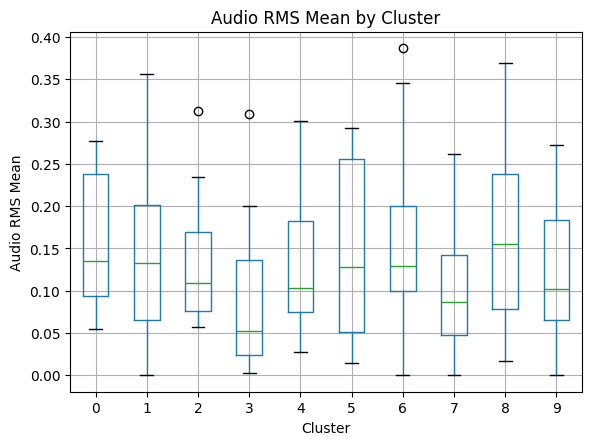

<Figure size 1000x400 with 0 Axes>

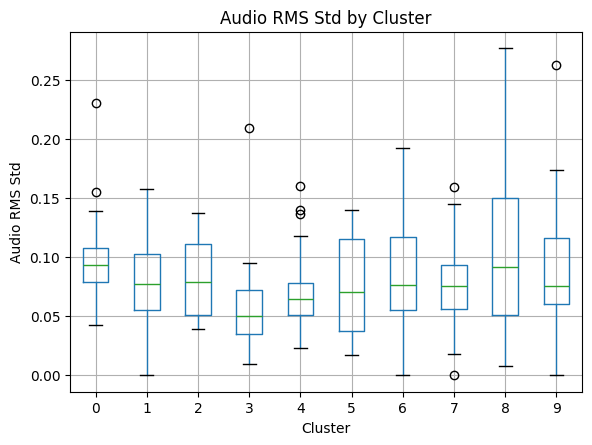

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("interpretation.csv")

# loudness by cluster
plt.figure(figsize=(10,4))
df.boxplot(column="audio_rms_mean", by="cluster")
plt.suptitle("")
plt.title("Audio RMS Mean by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Audio RMS Mean")
plt.show()

# dynamics by cluster
plt.figure(figsize=(10,4))
df.boxplot(column="audio_rms_std", by="cluster")
plt.suptitle("")
plt.title("Audio RMS Std by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Audio RMS Std")
plt.show()


### Visual Density


Estimate how "busy" a frame is by counting edges(how fast brightness changes)

Higher visual density -> more text/objects/details.  
Lower visual density -> cleaner, simpler visuals.

In [49]:
def visual_density(video_path, fps_sample=1, edge_thresh=EDGE_THRESH):
    if not Path(video_path).exists():
        return 0.0

    container = av.open(str(video_path))
    stream = container.streams.video[0]
    src_fps = float(stream.average_rate) if stream.average_rate else 30.0
    step = max(1, int(src_fps / fps_sample))

    densities = []
    frame_idx = 0
    for frame in container.decode(video=0):
        if frame_idx % step != 0:
            frame_idx += 1
            continue
        #convert to grayscale
        gray = frame.to_ndarray(format="gray").astype(np.float32)
        gy, gx = np.gradient(gray)
        #calculate magnitude of gradient
        mag = np.sqrt(gx**2 + gy**2)
        densities.append((mag > edge_thresh).mean())
        frame_idx += 1

    return float(np.mean(densities)) if densities else 0.0

vd_rows = []
for i, (_, row) in enumerate(clusters.iterrows(), start=1):
    print(f"{i}/{len(clusters)} {row['video_id']}")
    vd_rows.append({"video_id": row["video_id"], "visual_density": visual_density(row["video_path"])})

vd_df = pd.DataFrame(vd_rows)

#save
out_df = out_df.merge(vd_df, on="video_id", how="left")
out_df.to_csv(INTERPRET_CSV, index=False)

1/222 challenge Shorts13
2/222 challenge Shorts16
3/222 challenge Shorts19
4/222 challenge Shorts9
5/222 funny Shorts10
6/222 funny Shorts4
7/222 meme Shorts7
8/222 recipe Shorts11
9/222 recipe Shorts15
10/222 recipe Shorts20
11/222 recipe Shorts3
12/222 recipe Shorts8
13/222 recipe Shorts9
14/222 tech Shorts13
15/222 tech Shorts14
16/222 tech Shorts16
17/222 tech Shorts17
18/222 tech Shorts18
19/222 tech Shorts4
20/222 travel Shorts15
21/222 travel Shorts17
22/222 travel Shorts8
23/222 ai Shorts10
24/222 ai Shorts3
25/222 challenge Shorts5
26/222 educational Shorts8
27/222 fashion Shorts10
28/222 fashion Shorts12
29/222 fashion Shorts14
30/222 fashion Shorts2
31/222 gaming Shorts11
32/222 gaming Shorts14
33/222 gaming Shorts17
34/222 gaming Shorts3
35/222 gaming Shorts5
36/222 motivational Shorts10
37/222 motivational Shorts11
38/222 motivational Shorts15
39/222 motivational Shorts20
40/222 music Shorts14
41/222 music Shorts7
42/222 random Shorts12
43/222 reaction Shorts11
44/222 reac

Visualize Visual Density per Cluster

<Figure size 1000x400 with 0 Axes>

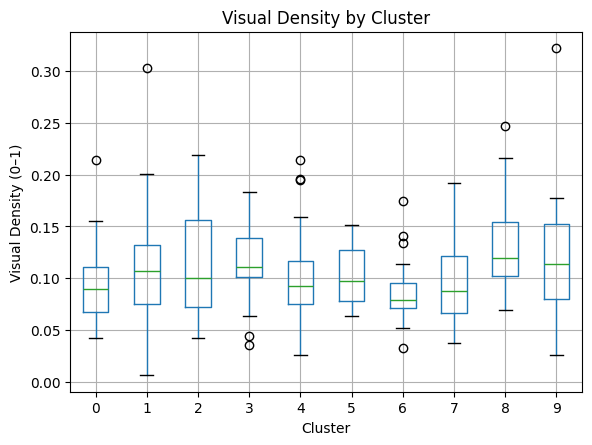

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("interpretation.csv")

plt.figure(figsize=(10,4))
df.boxplot(column="visual_density", by="cluster")
plt.suptitle("")
plt.title("Visual Density by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Visual Density (0–1)")
plt.show()